# *Random Forest* classification of Loan Repayment data 

Prediction of the loan behaviour class of a loan ID (good or bad) based on a set of input features using **Random Forest**.

- Up to **6** preprocessed input features available per loan ID 

**Tasks**:
- Preprocess the data for suitable input features
- Preparing the data for Scikit Learn  
- Creating a training and testing sample 
- Running the decision tree classification process and evaluate predictive power  
- Investigating prediction accuracy changes with hyper-parameter tuning 

#### Import required package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams

from sklearn import datasets, tree, metrics, model_selection, ensemble
from IPython.display import Image

import dt_utils

Using TensorFlow backend.


#### Configure display output setting

In [2]:
#Set the figure size
rcParams['figure.figsize'] = 5, 5

#Widen the output display to see more columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Data Extraction
- The features can be any of the following: 
  - <font color='blue'>APR</font> - The APR percentage of the loan
  - <font color='blue'>loanAmount</font> - Principal of the loan
  - <font color='blue'>originallyScheduledPaymentAmount</font> - The amount of MoneyLion should received from applicant
  - <font color='blue'>loanStatus</font> - The current loan status of the applicant
  - <font color='blue'>leadCost</font> - The cost for the underwriting rules for the lead
  - <font color='blue'>topPaymentStatus</font> - The most frequent payment status of applicant for among all payment attempt made.
- The target is <font color='red'>badLoanBehaviour</font>.

In [3]:
payment = 'data/payment_processed.csv'
loan = 'data/loan.csv'

In [4]:
df, label    = dt_utils.preprocess(payment, loan)
target_class = np.array(['Good LB', 'Bad LB'])
feature      = df.dtypes.index[:-1]

In [5]:
df.head()

,apr,loanAmount,originallyScheduledPaymentAmount,loanStatus,leadCost,topPS,badLoanBehaviour
0,478.67,800.0,2035.32,0,25,0,0
1,478.67,800.0,1919.28,1,6,1,1
2,478.67,800.0,1919.28,1,25,0,1
3,705.59,200.0,739.08,1,25,1,1
4,478.67,500.0,1199.55,1,25,1,1


In [6]:
data, target = df.values[:, 0:-1], df.values[:, [-1]].ravel().astype('int')

# Show dataset dimensions
data.shape, target.shape, np.unique(target)

((39952, 6), (39952,), array([0, 1]))

#### The feature distribution of the selected observations

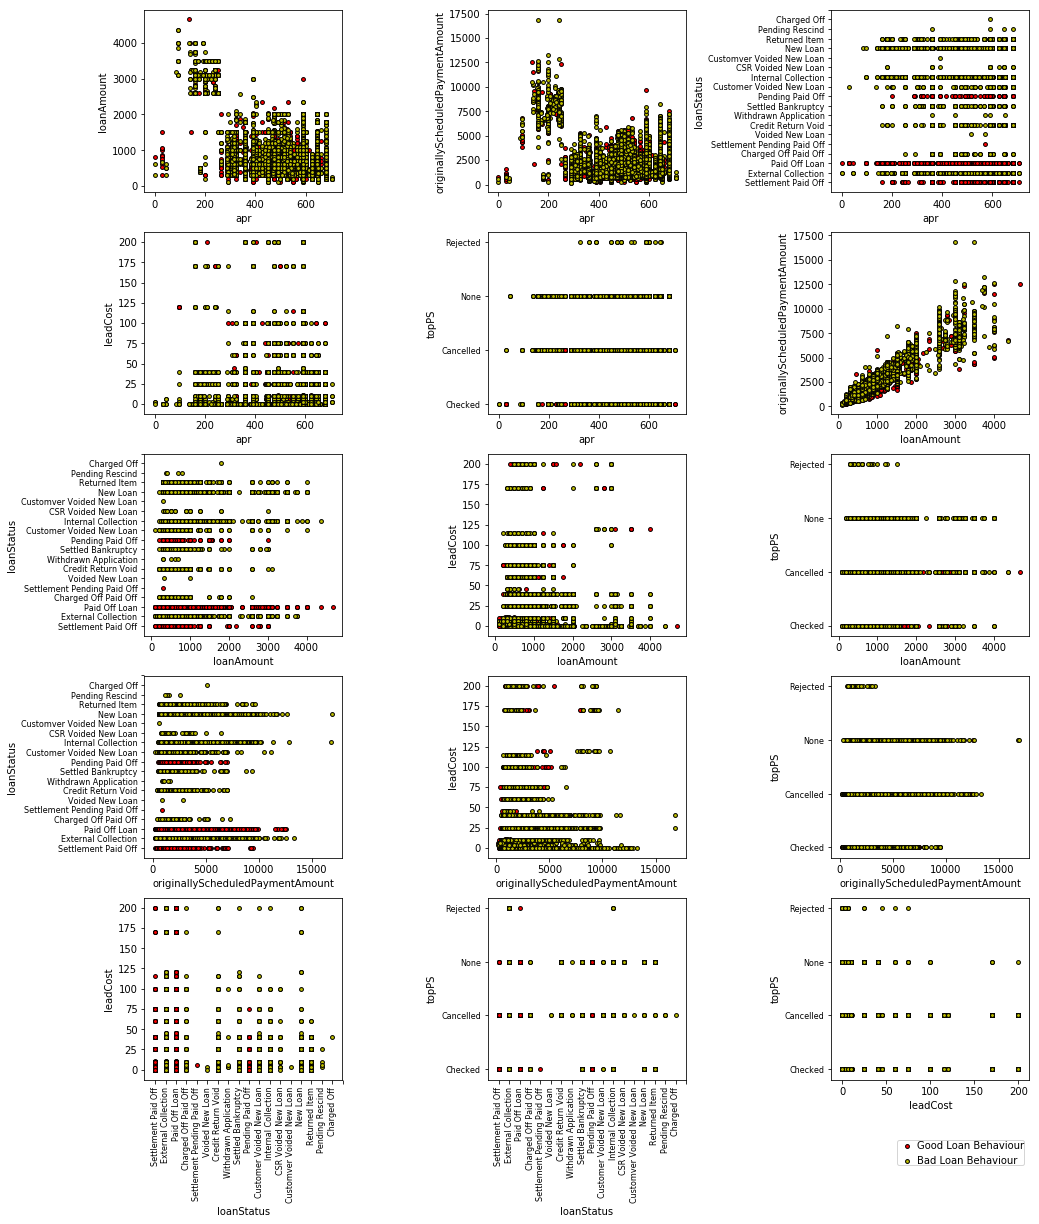

In [7]:
# # generate 2D plots 
dt_utils.featuresplot(data, target, label, feature, label['badLoanBehaviour'])
plt.show()

In [8]:
# train test split
d = model_selection.train_test_split(
    data, target, test_size=0.3, random_state=0)

# get training and test data and targets
train_data, test_data, train_target, test_target = d

# train_target, test_target = train_target.astype('int'), test_target.astype('int')

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(27966, 6) (27966,) (11986, 6) (11986,)


In [9]:
# define classifier 
clf = ensemble.RandomForestClassifier(n_estimators=10, max_features=4)

fit = clf.fit(train_data, train_target)

# define expected and predicted 
expected, predicted = dt_utils.runML(clf, d)

#### Displaying the generated decision tree logic by single tree extraction

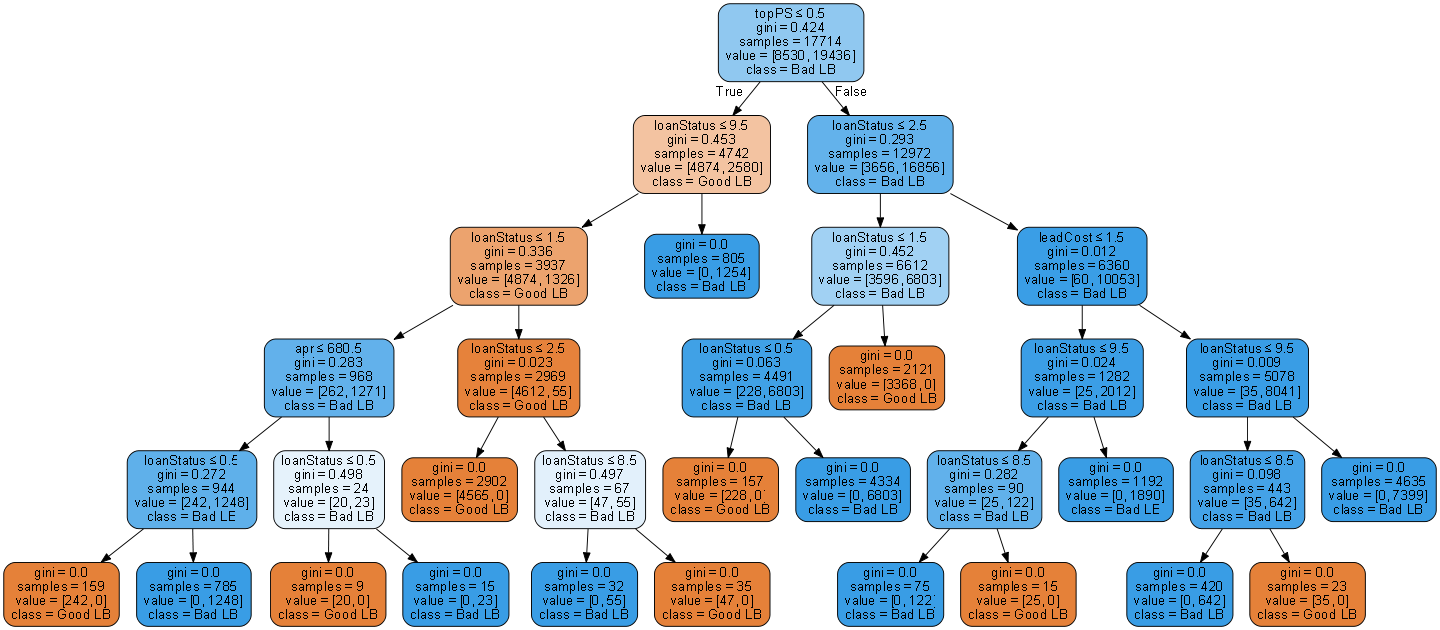

In [10]:
# plot tree
estimator = clf.estimators_[5]
graph = dt_utils.plotDT(estimator, feature, target_class)
Image(graph.create_png())

#### Displaying the classification report and confusion matrix for the predictions using the test sample

In [11]:
# display classification report
report = metrics.classification_report(expected, predicted, target_names=target_class)
print(report)

# accuracy score 
acc = metrics.accuracy_score(expected, predicted)
print('Accuracy : {}'.format(acc*100))

             precision    recall  f1-score   support

    Good LB       1.00      1.00      1.00      3720
     Bad LB       1.00      1.00      1.00      8266

avg / total       1.00      1.00      1.00     11986

Accuracy : 100.0


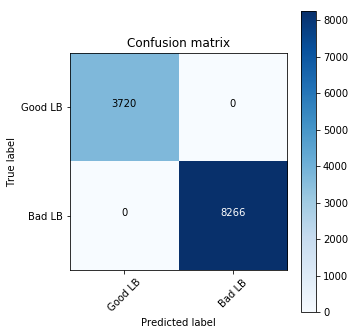

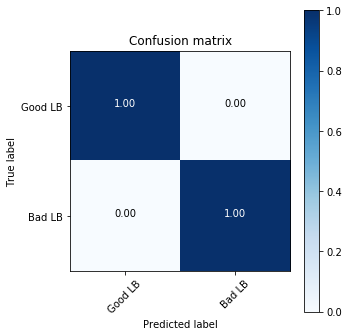

In [12]:
# display confusion matrix
cm = metrics.confusion_matrix(expected, predicted)

# plot confusion matrix 
dt_utils.plot_cm(cm, target_class)
plt.show()

# normalized confusion matrix
dt_utils.plot_cm(cm, target_class, normalize=True)
plt.show()

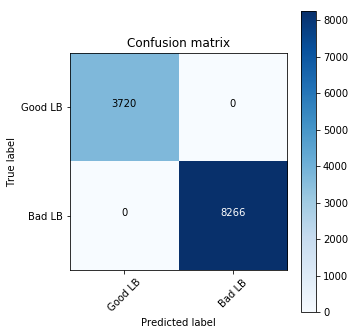

In [13]:
# display confusion matrix
cm = metrics.confusion_matrix(expected, predicted)
# plot confusion matrix 
dt_utils.plot_cm(cm, target_class)
plt.show()

#### Running the cross-validation to determine the average accuracy
- Splitting the data into **5** folds and using the whole dataset as part of the cross-validation

In [14]:
scores = model_selection.cross_val_score(clf, data, target, cv=5)
print(scores)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.99987486 1.         0.99987484 1.         0.99987484]
CV Accuracy: 1.00 (+/- 0.00)


#### Plotting the feature importance graph to determine significance features

Feature ranking:
1.                         loanStatus    0.9004
2.                              topPS    0.0852
3.                           leadCost    0.0127
4.   originallyScheduledPaymentAmount    0.0011
5.                                apr    0.0004
6.                         loanAmount    0.0003


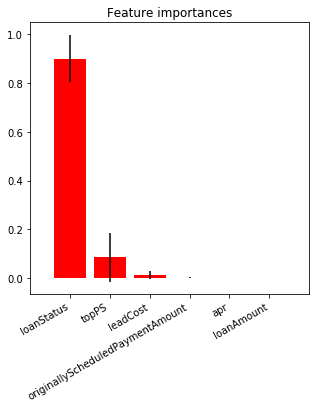

In [15]:
dt_utils.featureImportance(clf, train_data, feature)

#### Performing a grid-search on **two** suitable hyper-parameters to look for higher accuracy

In [16]:
%%time
# estimate hyperparameter
params = {
            'n_estimators' :  [10, 50, 100],
            'max_features' : [2, 4, 6]
         }
score = 'accuracy'

# tuning hyperparameter
clf = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), params, cv=5, scoring='%s' % score)
clf.fit(train_data, train_target)

# define expected and predicted 
expected1 = test_target
predicted1 = clf.predict(test_data)
print(clf.best_params_)

# Calculate the means and stds test score
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, param in zip(means, stds, clf.cv_results_['params']):
    print("{0:0.3f} (+/-{1:0.03f}) for {2}".format(mean, std * 2, param))

{'n_estimators': 10, 'max_features': 4}
0.999 (+/-0.001) for {'n_estimators': 10, 'max_features': 2}
1.000 (+/-0.000) for {'n_estimators': 50, 'max_features': 2}
1.000 (+/-0.000) for {'n_estimators': 100, 'max_features': 2}
1.000 (+/-0.000) for {'n_estimators': 10, 'max_features': 4}
1.000 (+/-0.000) for {'n_estimators': 50, 'max_features': 4}
1.000 (+/-0.000) for {'n_estimators': 100, 'max_features': 4}
1.000 (+/-0.000) for {'n_estimators': 10, 'max_features': 6}
1.000 (+/-0.000) for {'n_estimators': 50, 'max_features': 6}
1.000 (+/-0.000) for {'n_estimators': 100, 'max_features': 6}
Wall time: 30 s


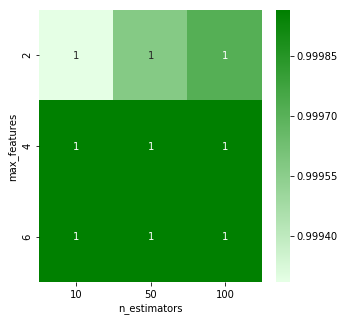

In [17]:
# display heatmap
labels = [k for k,v in params.items()]
classes = [v for k,v in params.items()]
dt_utils.heatmap(means.reshape(3, 3), classes=classes, labels=labels, palette="Green")